In [2]:
from FastChemTokenizer import FastChemTokenizerSelfies
# --- Load the tokenizer ---
tokenizer = FastChemTokenizerSelfies.from_pretrained("./selftok_core")

# Test it
out = tokenizer("[C]", return_tensors="pt")
print(out.input_ids)          # ← Attribute access works
print(out.attention_mask)     # ← Also works
out = out.to("cuda")          # ← Moves all tensors to GPU
print(out.input_ids.device)   # ← Should be cuda:0

tensor([[  0, 379,   1]])
tensor([[1, 1, 1]])
cuda:0


In [4]:
import torch
from ChemQ3MTP import ChemQ3MTP
# --- Initialize model from scratch ---

model = ChemQ3MTP.from_pretrained('./pretrained/sample-e1-mtp')

# --- Print model parameter count ---
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters.")

# --- Quick forward pass sanity check ---
batch_size, seq_len = 2, 32
dummy_input = torch.randint(
    low=0,
    high=len(tokenizer),
    size=(batch_size, seq_len),
    dtype=torch.long,
)

with torch.no_grad():
    outputs = model(dummy_input)
    logits = outputs.logits

print(f"Input shape: {dummy_input.shape}")
print(f"Logits shape: {logits.shape}")  # should be [batch_size, seq_len, vocab_size]


Model has 9,854,851 trainable parameters.
Input shape: torch.Size([2, 32])
Logits shape: torch.Size([2, 32, 782])


In [5]:
# Generate SELFIES
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = tokenizer("<s>", return_tensors="pt").input_ids.to(device)
gen = model.generate(input_ids, max_length=256, top_k=50, temperature=1, do_sample=True, pad_token_id=tokenizer.pad_token_id)
print(tokenizer.decode(gen[0], skip_special_tokens=True))

[=N] [N] [=C] [Branch2] [Ring1] [Ring1] [C] [=C] [C] [=C] [C] [Branch1] [#Branch2] [O] [C] [Branch1] [C] [F] [Branch1] [C] [F] [F] [=C] [Ring1] [O] [O] [C] [=C] [C] [=C] [Branch1] [C] [F] [C] [Branch1] [C] [F] [=C] [Ring1] [Branch2]


In [7]:
# Manually convert it to SMILES
import selfies as sf

test = tokenizer.decode(gen[0], skip_special_tokens=True)
test = test.replace(' ', '')
print(sf.decoder(test))


NN=C(C1=CC=CC(OC(F)(F)F)=C1)OC2=CC=C(F)C(F)=C2


CC1CCCC1CCC2(NC3=CC=C(C(N)=O)C=C3[NH1]C2)C(=O)O


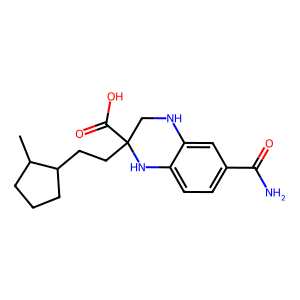

In [15]:
# Generate Mol Viz
from rdkit import Chem
from rdkit.Chem import Draw

input_ids = tokenizer("<s>", return_tensors="pt").input_ids.to(device)
gen = model.generate(input_ids, max_length=256, top_k=50, temperature=1, do_sample=True, pad_token_id=tokenizer.pad_token_id)
generatedmol = tokenizer.decode(gen[0], skip_special_tokens=True)

test = generatedmol.replace(' ', '')
csmi_gen = sf.decoder(test)
print(csmi_gen)
mol = Chem.MolFromSmiles(csmi_gen)

# Draw the molecule
Draw.MolToImage(mol)